## AIN212 Text Analysis Project

Dataset URL: https://www.kaggle.com/datasets/chaudharyanshul/airline-reviews

Student Names: Berke Kutlu, Emir Çağıl Kökdener

Student IDs: 2210765022, 2220765036

In [28]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [29]:
# Loading the dataset
path = "BA_AirlineReviews.csv"
df = pd.read_csv(path)
df.head()


,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [30]:
# Checking the size of the dataset and printing out total of empty cells on any row for each column
print(df.shape)
print(df.isnull().sum())

(3701, 20)
Unnamed: 0                  0
OverallRating               5
ReviewHeader                0
Name                        0
Datetime                    0
VerifiedReview              0
ReviewBody                  0
TypeOfTraveller           771
SeatType                    2
Route                     775
DateFlown                 778
SeatComfort               116
CabinStaffService         127
GroundService             846
ValueForMoney               1
Recommended                 0
Aircraft                 1779
Food&Beverages            386
InflightEntertainment    1150
Wifi&Connectivity        3092
dtype: int64


As you can see there are 20 columns and some of them are redundant. So we need to clean the data to operate on it smoothly. 
There are so many empty cells on this dataset. To make dataset still usable we have to delete some of the redundant and mostly empty columns. These columns are: 

    Unnamed: 0, Name, Datetime, VerifiedReview, Route, DateFlown, Aircraft, InflightEntertainment, Wifi&Connectivity

In [31]:
# Removing redundant and mostly empty columns
rColumns = ["Unnamed: 0", "OverallRating", "Name", "Datetime", "VerifiedReview", "Route",
            "DateFlown", "Aircraft", "InflightEntertainment", "Wifi&Connectivity"]

df = df.drop(columns=rColumns)
df = df.dropna()
print(df.shape)
print(df.head())

(2534, 10)
                               ReviewHeader  \
1  "do not upgrade members based on status"   
2             "Flight was smooth and quick"   
4        "Customer Service is non existent"   
5         "I can’t imagine a worst airline"   
6             "sufficient leg and arm room"   

                                          ReviewBody TypeOfTraveller  \
1  I recently had a delay on British Airways from...        Business   
2  Boarded on time, but it took ages to get to th...  Couple Leisure   
4  We traveled to Lisbon for our dream vacation, ...  Couple Leisure   
5  Booked a flight from Bucharest to Manchester w...    Solo Leisure   
6  Booked online months ago and the only hitch wa...  Couple Leisure   

          SeatType  SeatComfort  CabinStaffService  GroundService  \
1    Economy Class          2.0                3.0            1.0   
2   Business Class          3.0                3.0            4.0   
4    Economy Class          1.0                1.0            1.0 

Now we have to encode our categorical columns which are: TypeOfTraveller, SeatType

In [32]:
# Categories of the categorical columns
print(df["TypeOfTraveller"].unique())
print(df["SeatType"].unique())

['Business' 'Couple Leisure' 'Solo Leisure' 'Family Leisure']
['Economy Class' 'Business Class' 'Premium Economy' 'First Class']


In [33]:
# Encoding categorical variaables
labelEncTraveller = LabelEncoder()
labelEncSeat = LabelEncoder()
labelEncRecommended = LabelEncoder()

df["TravellerEncoded"] = labelEncTraveller.fit_transform(df["TypeOfTraveller"])
df["SeatEncoded"] = labelEncSeat.fit_transform(df["SeatType"])
df["RecommendedEncoded"] = labelEncRecommended.fit_transform(df["Recommended"])
df.head()

,ReviewHeader,ReviewBody,TypeOfTraveller,SeatType,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Food&Beverages,TravellerEncoded,SeatEncoded,RecommendedEncoded
1,"""do not upgrade members based on status""",I recently had a delay on British Airways from...,Business,Economy Class,2.0,3.0,1.0,2.0,no,1.0,0,1,0
2,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,3.0,3.0,4.0,3.0,yes,4.0,1,0,1
4,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,no,1.0,1,1,0
5,"""I can’t imagine a worst airline""",Booked a flight from Bucharest to Manchester w...,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,no,1.0,3,1,0
6,"""sufficient leg and arm room""",Booked online months ago and the only hitch wa...,Couple Leisure,Premium Economy,5.0,5.0,4.0,4.0,yes,4.0,1,3,1


Also we have to know if the review header and body are positive. To know if they are positive or not we have to use sentiment analysis using NLP

In [34]:
nltk.download("vader_lexicon")
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Emir\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
# Setting polarity scores for the text values
df["HeaderScore"] = df["ReviewHeader"].apply(lambda text: analyzer.polarity_scores(text)['compound'])
df["BodyScore"] = df["ReviewBody"].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df.head()

,ReviewHeader,ReviewBody,TypeOfTraveller,SeatType,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Food&Beverages,TravellerEncoded,SeatEncoded,RecommendedEncoded,HeaderScore,BodyScore
1,"""do not upgrade members based on status""",I recently had a delay on British Airways from...,Business,Economy Class,2.0,3.0,1.0,2.0,no,1.0,0,1,0,0.0000,-0.8500
2,"""Flight was smooth and quick""","Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,3.0,3.0,4.0,3.0,yes,4.0,1,0,1,0.0000,0.5927
4,"""Customer Service is non existent""","We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,no,1.0,1,1,0,0.0000,0.8392
5,"""I can’t imagine a worst airline""",Booked a flight from Bucharest to Manchester w...,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,no,1.0,3,1,0,-0.6249,-0.7269
6,"""sufficient leg and arm room""",Booked online months ago and the only hitch wa...,Couple Leisure,Premium Economy,5.0,5.0,4.0,4.0,yes,4.0,1,3,1,0.0000,0.5956


We cleaned our dataset and it is still useful. We didnt have the need to remove any outliers because the customer can rate any category anything he/she wants. Also The thing our algorithms have to predict is the recommendation (Recommended column). We decided to use K-nn and Logistic Regression in our project so we can classify the reviews better.

### Data Analysis
After cleaning the data, firstly, we have to see the clustering analysis of our data.

In [36]:
# Getting the numerical columns
dropCols = ["ReviewHeader", "ReviewBody", "TypeOfTraveller", "SeatType", "Recommended", "RecommendedEncoded"]
numDF = df.drop(columns=dropCols)
numDF.head()

,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Food&Beverages,TravellerEncoded,SeatEncoded,HeaderScore,BodyScore
1,2.0,3.0,1.0,2.0,1.0,0,1,0.0000,-0.8500
2,3.0,3.0,4.0,3.0,4.0,1,0,0.0000,0.5927
4,1.0,1.0,1.0,1.0,1.0,1,1,0.0000,0.8392
5,1.0,1.0,1.0,1.0,1.0,3,1,-0.6249,-0.7269
6,5.0,5.0,4.0,4.0,4.0,1,3,0.0000,0.5956


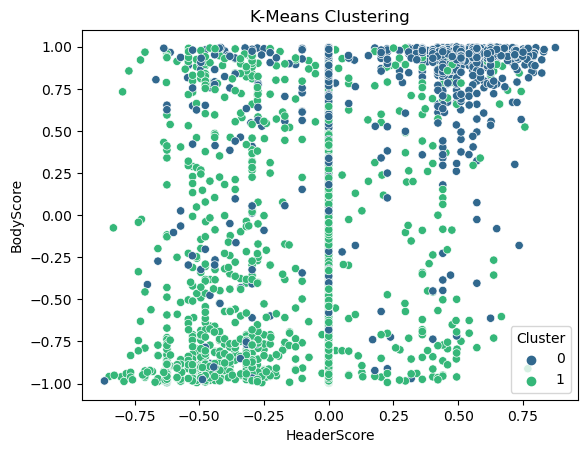

In [37]:
# K-Means Clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(numDF)
clusters = kmeans.predict(numDF)
numDF["Cluster"] = clusters

sns.scatterplot(x="HeaderScore", y="BodyScore", hue="Cluster", data=numDF, palette="viridis")
plt.title("K-Means Clustering")
plt.show()

When we try to use 

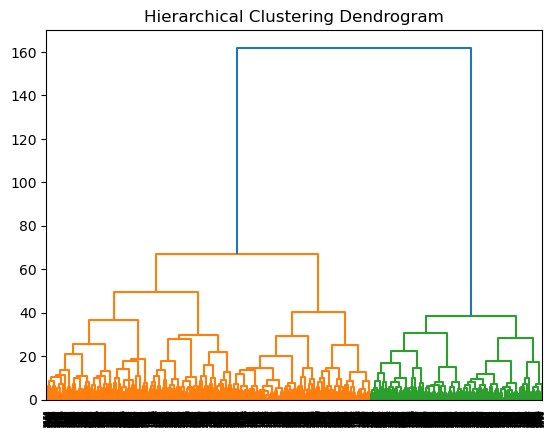

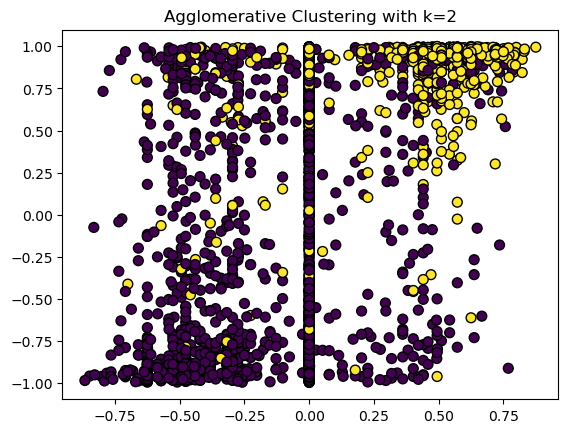

In [38]:
# Agglomerative Clustering
aCluster = AgglomerativeClustering(n_clusters=2)
numDF = numDF.drop("Cluster", axis=1)
aLabel = aCluster.fit_predict(numDF)

linked = linkage(numDF, 'ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

plt.scatter(numDF["HeaderScore"], numDF["BodyScore"], c=aLabel, cmap='viridis', edgecolor='k', s=50)
plt.title('Agglomerative Clustering with k=2')
plt.show()

As you can see both clustering algorithms are not the best approach to seperate the reviews because clusters doesnt have a spot that is mostly filled with only 1 cluster. Some are in the spot of a different cluster the reason for that is our data is not in the best shape for using a clustering algorithm.

### k-NN Algorithm

In [39]:
# dataset shuffle function
def splitTrainTest(df):
    shuffled_df = df.sample(frac=1)
    target = shuffled_df["RecommendedEncoded"]
    predict = shuffled_df.drop("RecommendedEncoded", axis=1)
    split = int(np.shape(shuffled_df)[0] * 0.7)
    # (train_predict, train_target, test_predict, test_target)
    return (predict[:split], target[:split], predict[split:], target[split:])

In [40]:
# Getting the numerical values from the dataset
dropCols = ["ReviewHeader", "ReviewBody", "TypeOfTraveller", "SeatType", "Recommended"]
finalDF = df.drop(columns=dropCols)
finalDF.head()

,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Food&Beverages,TravellerEncoded,SeatEncoded,RecommendedEncoded,HeaderScore,BodyScore
1,2.0,3.0,1.0,2.0,1.0,0,1,0,0.0000,-0.8500
2,3.0,3.0,4.0,3.0,4.0,1,0,1,0.0000,0.5927
4,1.0,1.0,1.0,1.0,1.0,1,1,0,0.0000,0.8392
5,1.0,1.0,1.0,1.0,1.0,3,1,0,-0.6249,-0.7269
6,5.0,5.0,4.0,4.0,4.0,1,3,1,0.0000,0.5956


In [41]:
# Implementing the knn algorithm and calculating the r2 score of it

(train_predict, train_target, test_predict, test_target) = splitTrainTest(finalDF)

knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(train_predict, train_target)

predictions = knn.predict(test_predict)
predictions = np.round(predictions)

r2 = r2_score(test_target, predictions)
print("R2 score with k=2: ", r2)

R2 score with k=2:  0.5737469993453117


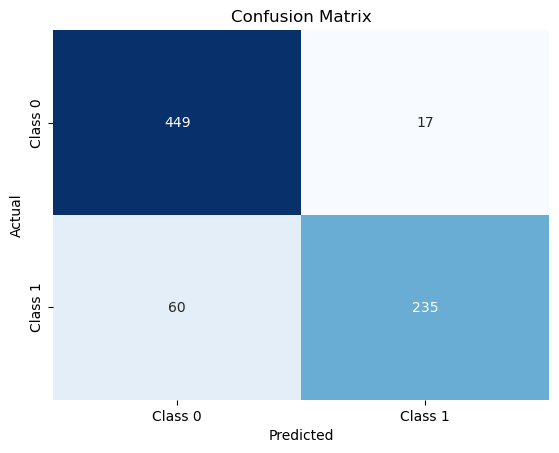

In [42]:
# Drawing the confusion matrix
confMatrix = confusion_matrix(test_target, predictions)

sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

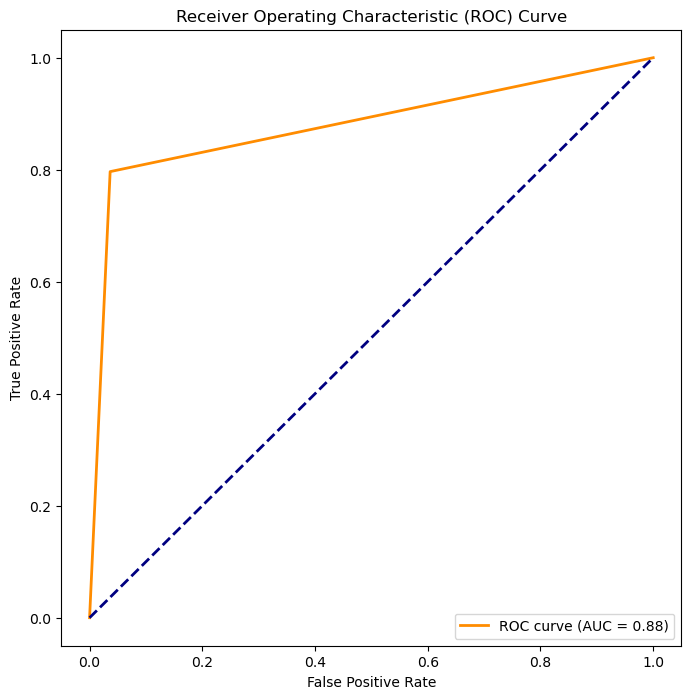

In [43]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(test_target, predictions)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {rocAUC:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

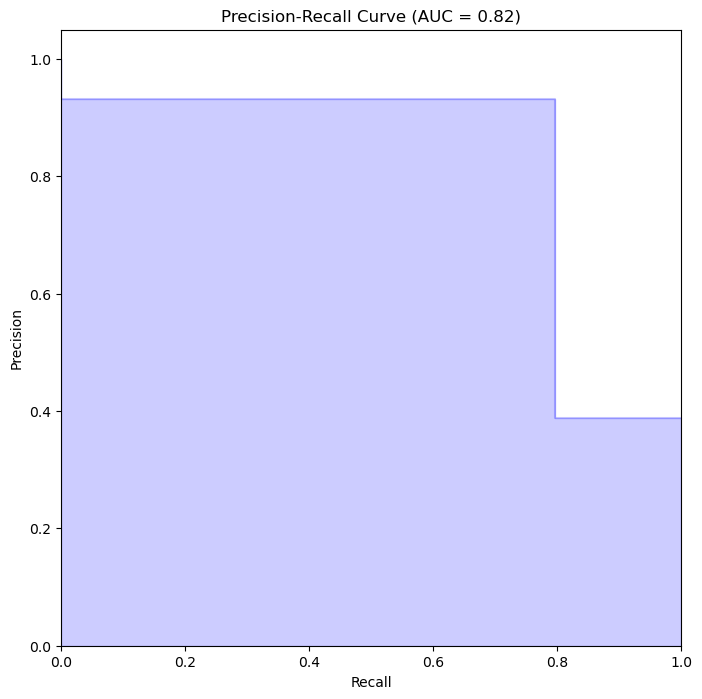

In [44]:
# Plotting Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_target, predictions)
avgPrecision = average_precision_score(test_target, predictions)

plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(avgPrecision))
plt.show()

As you can see we have finished our k-nn algorithm and it usually has a R2 score of between 0.52-0.65, Area under curve of a ROC curve is between 0.8-0.9 and area under the precision-recall curve is between 0.80-0.85. Also our precision recall curve and ROC curve is a little different that other kinds of precision-recall curver the reason for that is our data doesnt have a threshold, it only has to have a k value of 2 and lastly, most columns doesnt have variety.

The important thing is our model is a good approach to solving this dataset as you can see from the curves and matrices.

### Logistic Regression

In [45]:
# Implementing the logistic Regression algorithm and calculating the r2 score of it

(train_predict, train_target, test_predict, test_target) = splitTrainTest(finalDF)

lr = LogisticRegression()
lr.fit(train_predict, train_target)

predictions = lr.predict(test_predict)
predictions = np.round(predictions)

r2 = r2_score(test_target, predictions)
print("R2 score with logistic regression: ", r2)

R2 score with logistic regression:  0.695909619296716


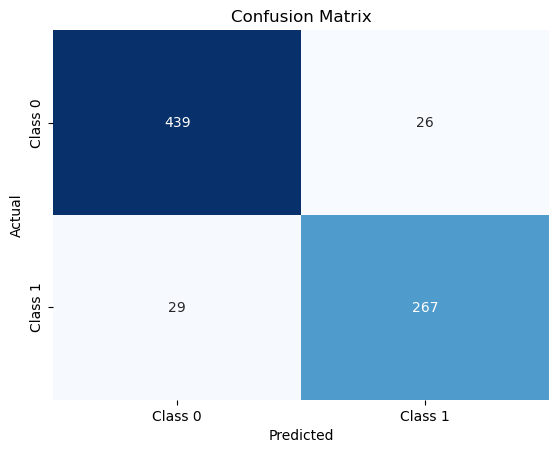

In [46]:
# Drawing the confusion matrix
confMatrix = confusion_matrix(test_target, predictions)

sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

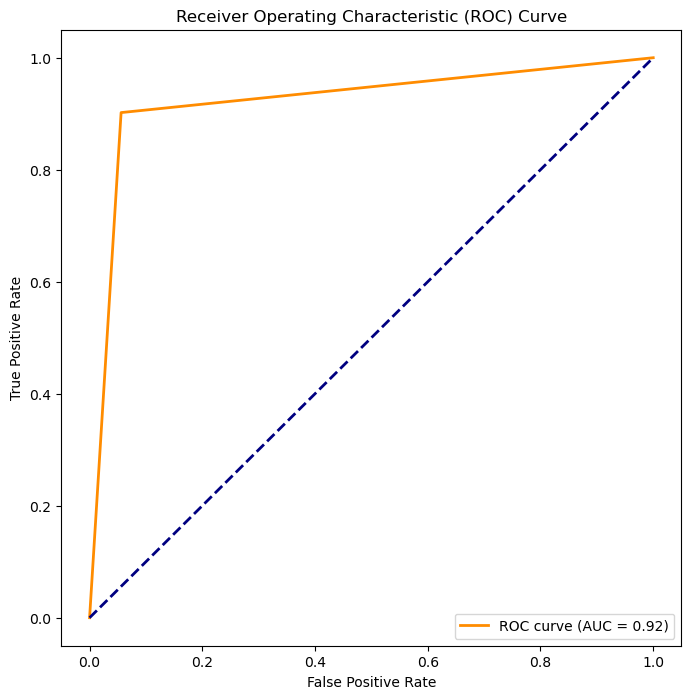

In [47]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(test_target, predictions)
rocAUC = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {rocAUC:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

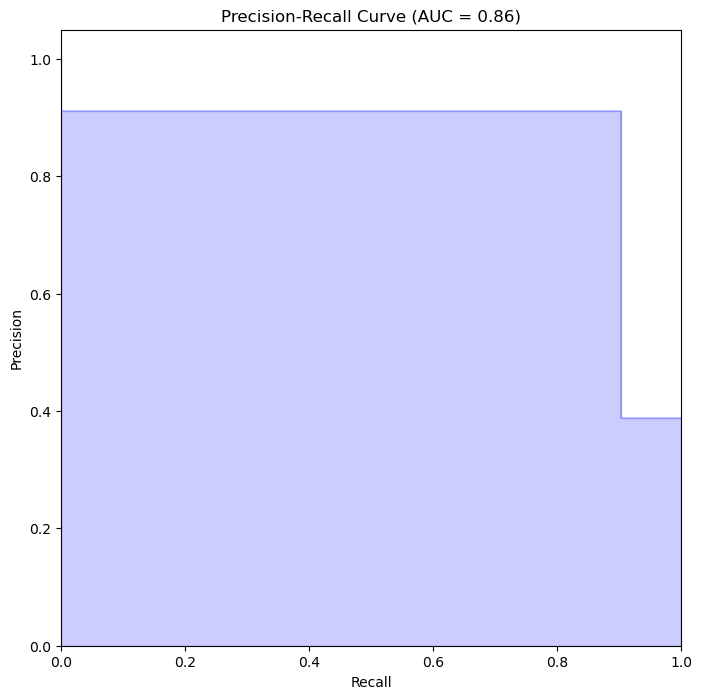

In [48]:
# Plotting Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_target, predictions)
avgPrecision = average_precision_score(test_target, predictions)

plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(avgPrecision))
plt.show()



As you can see we have finished our logistic regression algorithm and it has a 0.74 R2 score, Area under curve of a ROC curve is 0.93 and area under the precision-recall curve is between 0.88. 

We have linear relationship between features and our target so this model is better approach then the k-nn model as you can see from the R2 scores, curves and matrices.

### Report

In our data science project, we performed a data science life cycle on the data set we chose while learning the benefits of text analysis. The first part of the life cycle was choosing the dataset. We chose the airline rewies dataset and after that, we came up with a question. Can we predict whether the customer will recommend the flight? The second step of the cycle is data preprocessing and cleaning. We had many empty columns so we started our data cleaning by deleting redundant columns. Then we  encoded our category columns and we also checked if the review header and body were positive or not for sentiment analysis. The third step of the cycle is data exploration and analysis part for data exploration we can say some of the critical statistics are seat comfort, value for money, ground service, and some other numerical features that we can use to predict our target value(recommended) and for the analysis part we chose two clustering algorithms which are k means and agglomerative clustering. After the visualization of algorithms, we can say that clustering is not right for our dataset because it is mostly filled with only one cluster. The fourth part is predictive modelling. In this part firstly we write two classification algorithms which are k-nn and logistic regression. When we looked at their R2 scores we can say that logistic regression fits better to our dataset. Our parameter selection was rather easy because our features were the ones that were used in the overall rating. People recommend their flights based on their experience so if we know their experience on their flight we can come up with an algorithm that finds if the customer recommends the flight. The last part is model evaluation and visualization. In this part we showed confusion matrices, ROC curves, and precision recall curves this part helps us understand which model fits better to our dataset. In conclusion, we completed every step of the data science life cycle in our dataset and we had a good classification algorithm for our question to predict the recommended section of our dataset.